In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [195]:
class HopfieldNetwork:
    def __init__(self, type, patterns, weights = None):
        self.num_neurons = patterns.shape[1]
        self.num_patterns = patterns.shape[0]
        if type == 'manual':
            self.weights = weights
        elif type == 'hebbian':
            self.weights = np.zeros((self.num_neurons, self.num_neurons))
            
            for pattern in patterns:
                self.weights += np.outer(pattern, pattern)
            self.weights = self.weights / self.num_neurons
            np.fill_diagonal(self.weights, 0)  # Set diagonal elements to zero
        else:
            # binary (0, 1) with bias patterns
            average = np.mean(patterns)
            self.weights = np.zeros((self.num_neurons, self.num_neurons))
            
            for pattern in patterns:
                self.weights += np.outer(pattern - average, pattern - average)
            self.weights = self.weights / self.num_neurons
            np.fill_diagonal(self.weights, 0)  # Set diagonal elements to zero
    def energy(self, state):
        return -0.5 * np.dot(np.dot(state, self.weights), state)
    
    def asynchronous_update(self, state, max_iter=100):
        state = state.copy()
        energy_list = []
        for _ in range(max_iter):
            energy_iter = self.energy(state)
            energy_list.append(energy_iter)
            neuron_index = np.random.randint(self.num_neurons)  # Randomly select a neuron
            activation = np.dot(self.weights[neuron_index, :], state)
            state[neuron_index] = np.sign(activation)
        return state, energy_list
    
    def synchronous_update(self, state, max_iter = 100):
        state = state.copy()
        energy_list = []
        stop_iter = 0
        for _ in range(max_iter):
            energy_iter = self.energy(state)
            energy_list.append(energy_iter)
            new_state = np.sign(np.dot(self.weights, state))
            # print(_)
            if np.array_equal(new_state, state):
                stop_iter = _ + 1
                break
            state = new_state
        return state, energy_list, stop_iter
    
    def bias_update(self, state, theta, max_iter = 100):
        state = state.copy()
        # theta = np.mean(state)
        is_restore_successful = 0
        for _ in range(max_iter):
            new_state = 0.5 + 0.5 * np.sign(np.dot(self.weights, state) - theta)
            # print(_)
            if np.array_equal(new_state, state):
                is_restore_successful = 1
                break
            state = new_state
        return state, theta, is_restore_successful

In [40]:
def showImage(p):
   plt.figure()
   plt.imshow(p.reshape(32,32), cmap="binary")
   plt.show()

In [91]:
patterns = np.loadtxt('pict.dat', delimiter=",", dtype=int)
patterns = patterns.reshape((11, 1024))
p1 = patterns[0, :]
p2 = patterns[1, :]
p3 = patterns[2, :]
p10 = patterns[9]
p11 = patterns[10]

In [162]:
model = HopfieldNetwork('hebbian', patterns[:3,:])
# pn, energy = model.synchronous_update(p10, 100)
# showImage(p10)
# showImage(pn)
# plt.plot(energy)

In [86]:
def add_noise(pattern, percentage = 0.5):
    # randomly flipping certain percentage of units to add noise to pattern
    N = pattern.size
    n_index = int(N * percentage)
    index = np.random.choice(np.arange(N), n_index, replace=False)
    noisy_p = pattern.copy()
    noisy_p[index] = -noisy_p[index]
    return noisy_p

noise_tolenrance for p1: 0.25762626262626265
noise_tolenrance for p2: 0.3553030303030302
noise_tolenrance for p3: 0.21616161616161592


<BarContainer object of 3 artists>

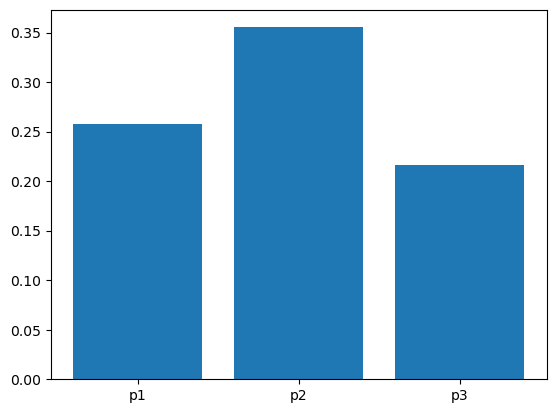

In [173]:
percentage = np.linspace(0, 1, 100)
max_iter = 200 # average noise tolenrance to reduce the influence of random noise

# compute respectively how much noise can be removed for p1, p2, p3
def compute_noise_tol(model, percentage, pattern, max_iter = 200):
    noise_tol = 0
    for _ in range(max_iter):
        for p in percentage:
            noise_p = add_noise(pattern, p)
            rp, _, _ = model.synchronous_update(noise_p)
            if not np.array_equal(rp, pattern):
                noise_tol += p
                break
            if p == 1:
                noise_tol += p

    return noise_tol / max_iter

noise_tol_p1 = compute_noise_tol(model, percentage, p1)
noise_tol_p2 = compute_noise_tol(model, percentage, p2)
noise_tol_p3 = compute_noise_tol(model, percentage, p3)

print("noise_tolenrance for p1:", noise_tol_p1)
print("noise_tolenrance for p2:", noise_tol_p2)
print("noise_tolenrance for p3:", noise_tol_p3)

numbers = [noise_tol_p1, noise_tol_p2, noise_tol_p3]
labels = ['p1', 'p2', 'p3']
plt.bar(labels, numbers)
plt.xlabel('')
plt.ylabel()
plt.title()

other attractors


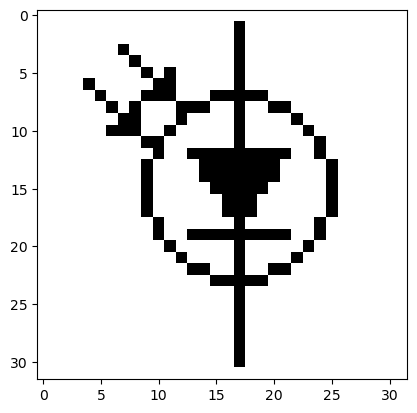

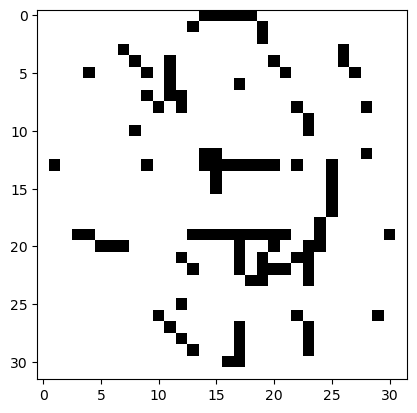

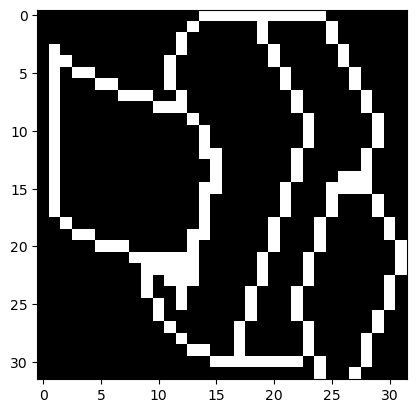

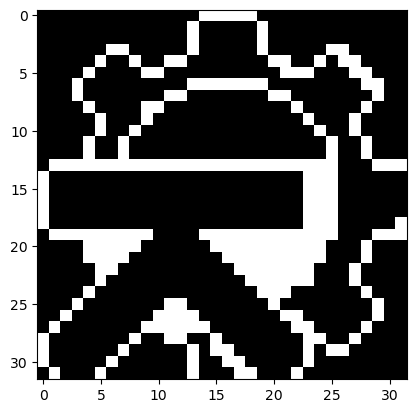

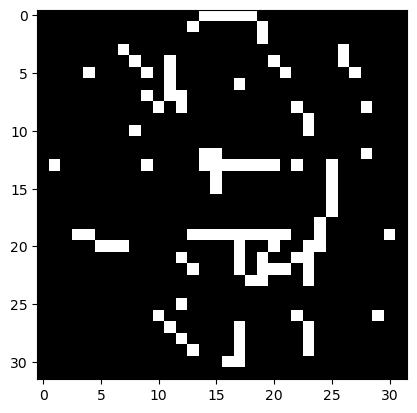

[1, 2, 2, 2, 2, 2, 2, 2, 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor']
[1, 2, 2, 2, 2, 2, 2, 2, 'not right attractor', 2, 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor']
[1, 2, 2, 2, 2, 2, 2, 2, 2, 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor', 'not right attractor']


In [171]:
def convergence_check(model, percentage, pattern):
    other_attractors = []
    stop_list = []
    for p in percentage:
        noise_p = add_noise(pattern, p)
        rp, _, stop_iter = model.synchronous_update(noise_p)
        if np.array_equal(rp, pattern):
            stop_list.append(stop_iter)
        else:
            stop_list.append('not right attractor')
        if not np.array_equal(rp, pattern):
            other_attractors.append(rp)

    return np.array(other_attractors), stop_list

percentage1 = np.linspace(0, 1, 20)

other_a1, stop_list1 = convergence_check(model, percentage1, p1)

other_a2, stop_list2 = convergence_check(model, percentage1, p2)

other_a3, stop_list3 = convergence_check(model, percentage1, p3)

other_a = np.concatenate((other_a1, other_a2, other_a3), axis = 0)
other_a = np.unique(other_a, axis = 0)
# print('original attractors')
# showImage(p1)
# showImage(p2)
# showImage(p3)
print('other attractors')
[showImage(i) for i in other_a]

print(stop_list1)
print(stop_list2)
print(stop_list3)

# Does the network always converge to the right attractor?
# No
# Do the extra iterations help?
# 
# Do you notice any other attractors?
# Yes, below pictures show other attractors

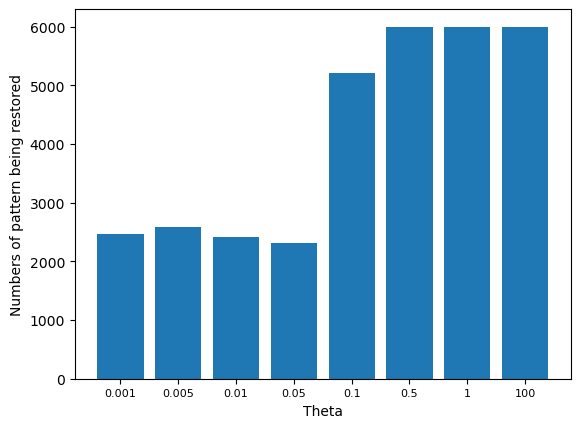

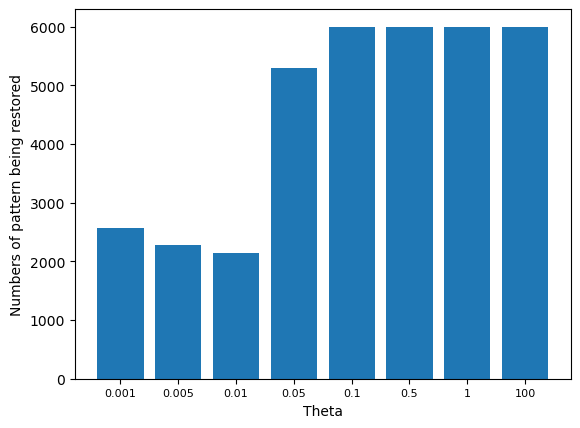

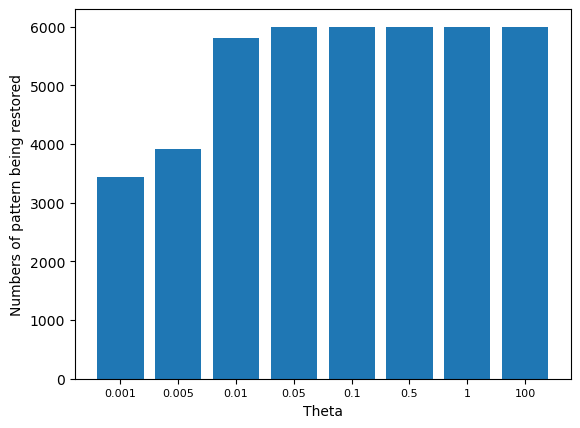

In [199]:
theta_val = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 100]

def theta_restore_histogram(activity, theta_val, max_iter = 20):
    cnt_restore = []
    for t in theta_val:
        cnt = 0
        for i in range(max_iter):
            pattern_10 = np.random.choice([0, 1], size=(300, 100),p=[1 - activity, activity]) #10% activation
            # print(pattern_10)
            model_spa = HopfieldNetwork('bias', pattern_10)
            for p in pattern_10:
                rp, theta, flag = model_spa.bias_update(p, t)
                # flag == 1 means restoring successfully, and == 0 means failing
                if flag:
                    cnt += 1
        cnt_restore.append(cnt)

    # print(theta_flag_dict)
    theta_val = [str(t) for t in theta_val]
    plt.bar(theta_val, cnt_restore)
    plt.xlabel('Theta')
    plt.xticks(fontsize = 8)
    plt.ylabel('Numbers of pattern being restored')
    plt.show()


theta_restore_histogram(0.1, theta_val)
theta_restore_histogram(0.05, theta_val)
theta_restore_histogram(0.01, theta_val)